# Benchmarking the speed of [fold](https://github.com/dream-faster/fold) and SKTime.

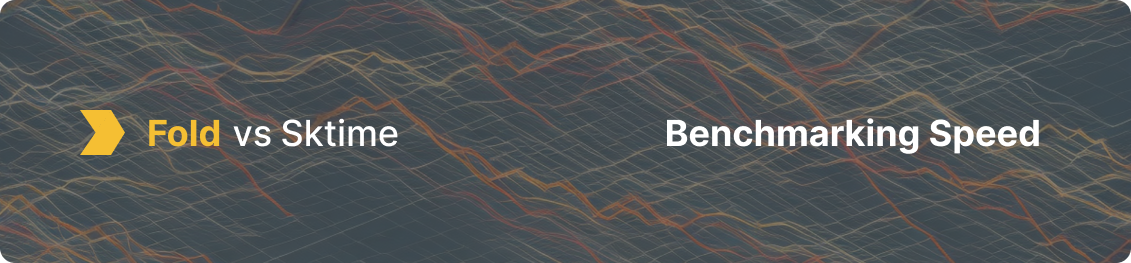

### Installing libraries, defining utility functions

In [1]:
%%capture
!pip install -q https://github.com/dream-faster/fold/archive/main.zip https://github.com/dream-faster/fold-models/archive/main.zip https://github.com/dream-faster/krisi/archive/main.zip sktime pmdarima ray xgboost kaleido

In [2]:
from time import monotonic
import pandas as pd
from collections import defaultdict
from krisi import score
from krisi.report import plot_y_predictions

class Timing:
    results = defaultdict(lambda: defaultdict(dict))
        
    def record_time(self, model_name: str, framework: str):
        def wrapper( function, *args, **kwargs):
            start_time = monotonic()
            return_value = function(*args, **kwargs)
            print(f"Run time: {monotonic() - start_time} seconds")

            self.results[framework][model_name] = monotonic() - start_time
            return return_value
        return wrapper
    def summary(self):
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.colheader_justify', 'center')
        pd.set_option('display.precision', 3)
        display(pd.DataFrame(self.results))

timing = Timing()

def flatten_result_windows(series: pd.Series) -> pd.Series:
    return pd.concat(series.to_list())

# Data Loading

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"

                     humidity  pressure  wind_speed  wind_direction  \
datetime                                                              
2012-10-01 13:00:00      88.0    1013.0         0.0             0.0   
2012-10-01 14:00:00      88.0    1013.0         0.0             0.0   
2012-10-01 15:00:00      88.0    1013.0         0.0             0.0   
2012-10-01 16:00:00      88.0    1013.0         0.0             0.0   
2012-10-01 17:00:00      88.0    1013.0         0.0             0.0   

                     temperature  
datetime                          
2012-10-01 13:00:00   291.870000  
2012-10-01 14:00:00   291.868186  
2012-10-01 15:00:00   291.862844  
2012-10-01 16:00:00   291.857503  
2012-10-01 17:00:00   291.852162  
datetime
2012-10-01 13:00:00    291.868186
2012-10-01 14:00:00    291.862844
2012-10-01 15:00:00    291.857503
2012-10-01 16:00:00    291.852162
2012-10-01 17:00:00    291.846821
Freq: H, Name: temperature, dtype: float64


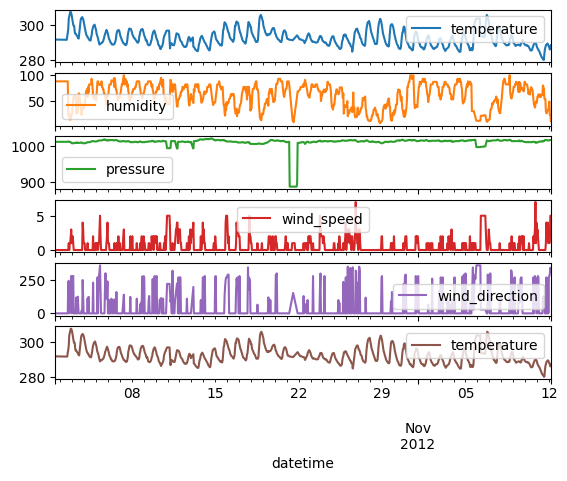

In [4]:
from fold.utils.dataset import get_preprocessed_dataset

X, y = get_preprocessed_dataset(
    "weather/historical_hourly_la", target_col="temperature", resample="H", shorten=1000
)

print(X.head());
print(y.head());
pd.concat([y,X], axis='columns').plot(subplots=True);

In [5]:
# Default values that both sktime and fold will receive

step_size = 50
initial_train_size = 300
lag_length_for_tabular_models = 10
fh=list(range(1, step_size+1))

# SKTime - Long forecasting horizon (Time Series Cross-Validation)

In [6]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter as SKTimeExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.pipeline import make_pipeline
from sktime.forecasting.compose import make_reduction

In [7]:
cv = SKTimeExpandingWindowSplitter(initial_window=initial_train_size, step_length=step_size, fh=fh)

### Naive

Run time: 0.2979092779999917 seconds


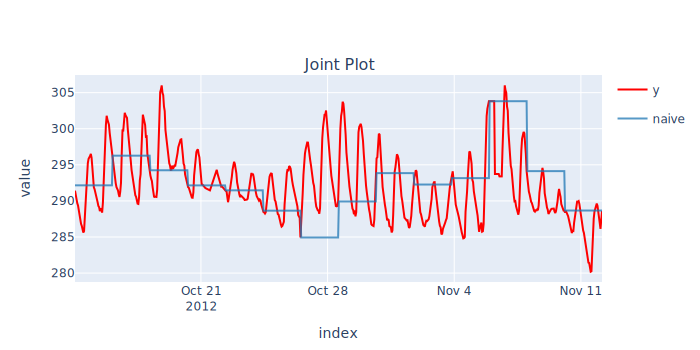

Root Mean Squared Error - 5.3689

In [8]:
forecaster = NaiveForecaster(strategy="last")
results = timing.record_time('naive', 'sktime (long-fh)')(evaluate, forecaster=forecaster, y=y, X=X, cv=cv, return_data=True, error_score='raise')
predictions = flatten_result_windows(results['y_pred']).rename("naive")
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

### Statsmodels ARIMA

Run time: 2.4895417860000038 seconds


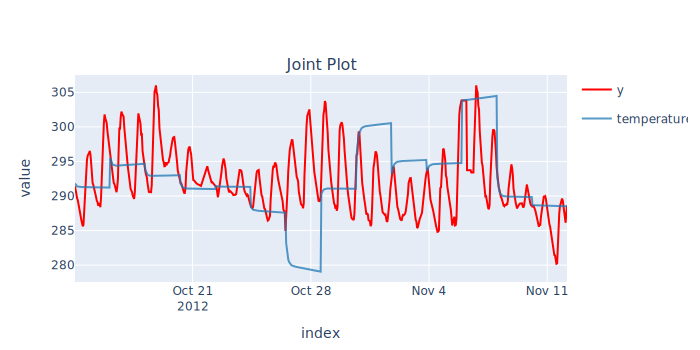

Root Mean Squared Error - 6.7435

In [9]:
forecaster = ARIMA((1,1,0))

results = timing.record_time('arima', 'sktime (long-fh)')(evaluate, forecaster=forecaster, y=y, cv=cv, return_data=True, error_score='raise')
predictions = flatten_result_windows(results['y_pred'])
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

A seasonal ARIMA - not suprisingly - provides much better results, but because of the slowness (and out of memory errors), we couldn't benchmark Statsmodels' implementation.

### XGBoost

Run time: 43.84174517699999 seconds


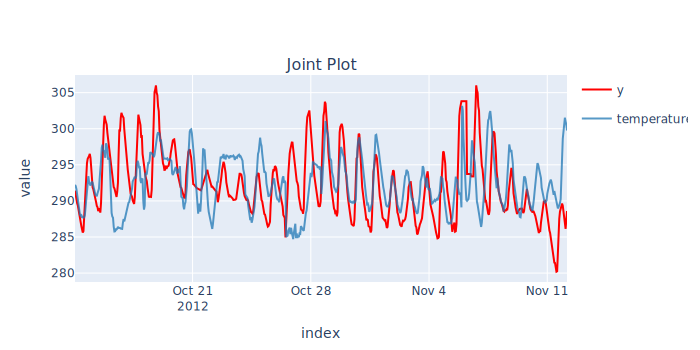

Root Mean Squared Error - 5.0444

In [10]:
from xgboost import XGBRegressor
regressor = XGBRegressor(random_state=42)

forecaster = make_reduction(regressor, strategy="recursive", window_length=lag_length_for_tabular_models)
results = timing.record_time('xgboost', 'sktime (long-fh)')(evaluate, forecaster=forecaster, y=y, X=X, cv=cv, backend="multiprocessing", return_data=True, error_score='raise')
predictions = flatten_result_windows(results['y_pred'])
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

### Results

In [11]:
timing.summary()

,sktime (long-fh)
arima,2.491
naive,0.298
xgboost,43.842


SKTime may look fast on its own, but it definitely falls short when it comes to the real usefulness of Time Series Cross-Validation.

The models are static, stuck in the past between end of the training windows, they don't have access to the latest value, and therefore their predictions are way off.

# Fold - Short forecasting horizon (Continuous Validation)

[fold](https://github.com/dream-faster/fold) has the ability to update models within the test window, in an "online" manner:

![](https://raw.githubusercontent.com/dream-faster/fold/main/docs/images/technical_diagrams/continous_online_inference.svg)

In [12]:
from fold import train_evaluate, ExpandingWindowSplitter, Backend
from fold.transformations import AddLagsX
from fold_models import WrapXGB, WrapStatsModels, Naive
from statsmodels.tsa.arima.model import ARIMA as StatsModelARIMA
from fold_models.baseline import Naive
import ray
ray.init(ignore_reinit_error=True)

2023-04-13 18:43:37,836	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


In [13]:
splitter = ExpandingWindowSplitter(initial_train_window=initial_train_size, step=step_size) 

### Naive

Run time: 0.1466155219999905 seconds


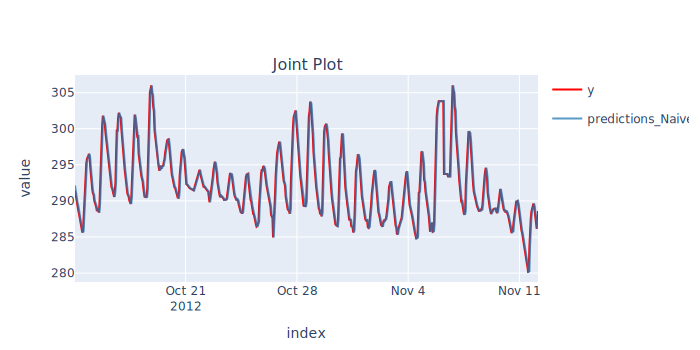

Root Mean Squared Error - 1.2239

In [14]:
model = Naive()

scorecard, predictions, _ = timing.record_time('naive', 'fold (online)')(train_evaluate, model, None, y, splitter, backend=Backend.no, silent=True)
plot_y_predictions(y[predictions.index], predictions, mode="overlap")
scorecard[['rmse']].print('minimal')

### Statsmodels ARIMA (Online)

Run time: 39.51998285799999 seconds


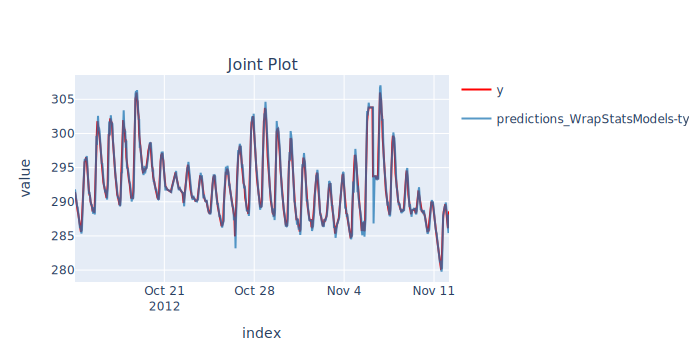

Root Mean Squared Error - 0.92664

In [15]:
model = WrapStatsModels(StatsModelARIMA, init_args=dict(order=(1, 1, 0)), online_mode=True)
scorecard, predictions, _ = timing.record_time('arima', 'fold (online)')(train_evaluate, model, None, y, splitter, backend=Backend.no, silent=True)
plot_y_predictions(y[predictions.index], predictions, mode="overlap")
scorecard[['rmse']].print('minimal')

### XGBoost

(process_pipeline_window pid=967) /usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
(process_pipeline_window pid=967)   warnings.warn(msg, FutureWarning)
(process_pipeline_window pid=966) /usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
(process_pipeline_window pid=966)   warnings.warn(msg, FutureWarning)
(process_pipeline_window pid=967) /usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
(process_pipeline_window pid=967)   warnings.warn(msg, FutureWarning)
(process_pipeline_window pid=966) /usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as keyword args.
(process_pipeline_window pid=966)   warnings.warn(msg, FutureWarning)
(process_pipeline_window pid=967) /usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `sample_weight` as

Run time: 12.67659457000002 seconds


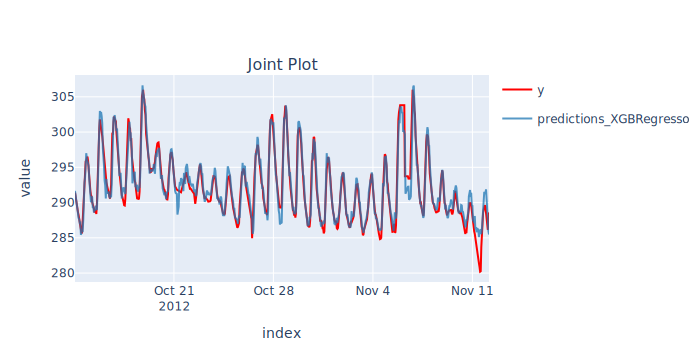

Root Mean Squared Error - 1.3085

In [16]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42)
pipeline = [AddLagsX(("all", list(range(lag_length_for_tabular_models))) ), model]

scorecard, predictions, _ = timing.record_time('xgboost', 'fold (online)')(train_evaluate, pipeline, X, y, splitter, backend=Backend.ray, silent=True)
plot_y_predictions(y[predictions.index], predictions, mode="overlap")
scorecard[['rmse']].print('minimal')

This results in much more realistic simulation of past performance (in case the last value is available in production).

### Results

In [17]:
timing.summary()

,sktime (long-fh),fold (online)
naive,0.298,0.148
arima,2.491,39.521
xgboost,43.842,12.678


And it's also substantially faster, except in the case of Statsmodels' ARIMA, which `fold` needs to update on every timestamp. Our own ARIMA (coming in April) will provide a ca. 100x speedup here.

# SKTime - Short forecasting horizon (Continuous Validation)

In [18]:
cv = SKTimeExpandingWindowSplitter(initial_window=initial_train_size, step_length=1, fh=1)

Now let's see what SKTime's training speed would be like if we wanted to replicate "Continuous Validation", and the models having access to the latest value within the folds.

This means we'll need to update (not possible with the tested models) or fit a new model for every timestamp we return.

### Naive

Run time: 15.774555942999996 seconds


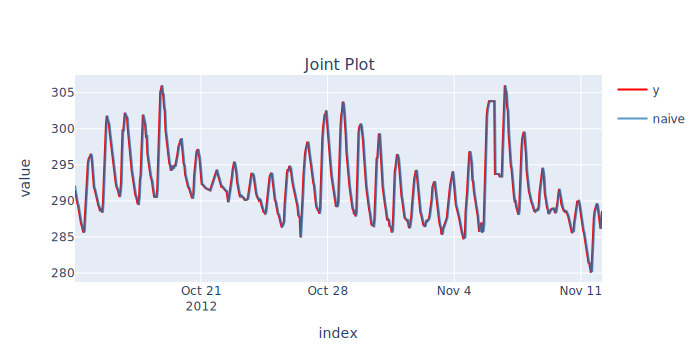

Root Mean Squared Error - 1.2239

In [19]:
forecaster = NaiveForecaster(strategy="last")
results = timing.record_time('naive', 'sktime (online)')(evaluate, forecaster=forecaster, y=y, X=X, cv=cv, return_data=True, strategy="refit", error_score='raise')
predictions = flatten_result_windows(results['y_pred']).rename("naive")
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

### Statsmodels ARIMA

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Run time: 101.52111907599999 seconds


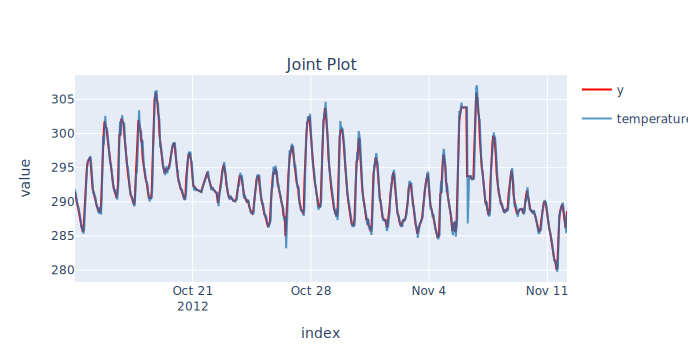

Root Mean Squared Error - 0.92736

In [20]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA((1,1,0))

results = timing.record_time('arima', 'sktime (online)')(evaluate, forecaster=forecaster, y=y, cv=cv, return_data=True, error_score='raise')
predictions = flatten_result_windows(results['y_pred'])
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

### XGBoost

In [ ]:
from xgboost import XGBRegressor
regressor = XGBRegressor(random_state=42)

forecaster = make_reduction(regressor, strategy="recursive", window_length=lag_length_for_tabular_models)
results = timing.record_time('xgboost', 'sktime (online)')(evaluate, forecaster=forecaster, y=y, X=X, cv=cv, backend=None, return_data=True, error_score='raise')
predictions = flatten_result_windows(results['y_pred'])
plot_y_predictions(y[predictions.index], predictions.to_frame(), mode="overlap")
score(y[predictions.index], predictions)[['rmse']].print('minimal')

# Overall Results

In [ ]:
timing.summary()

Overall, [`fold`](https://github.com/dream-faster/fold) provides a speedup between 3x and 100x, already.

When it comes to practice, we argue that this makes Continuos Validation feasible, compared to other tools out there.